# BAG3 Co-IP Pathway and Watson Analysis
##### by Emir Turkes

This analysis utilizes pathway analysis and Watson for Drug Discovery to validate and explore Co-IP MS (co-immunoprecipitation mass spectrometry) data with `BAG3` as the primary target. There are 4 goals thus far:
1. Correlation of our results with that of IBM's knowledge base to get a sense of where it stands against existing literature.
1. Clustering of the Co-IP'ed proteins into various ontological groups (disease relevance, biochemical pathways, and chemical classification).
1. Breakdown of upstream, downstream, and intermediate biochemical pathways between Co-IP'ed proteins and their clusters.
1. Confirmation of enrichment of proteins involved in endocytosis/membrane fusion event and dendritic localization/function.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*

# Copyright 2019 Emir Turkes
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""The main analysis routine."""


import os
import types

import numpy as np
import pandas as pd

import ibm_botocore.client as ic
import ibm_boto3 as ib
import pixiedust

Pixiedust database opened successfully


In [ ]:
# The code was removed by Watson Studio for sharing.

### Cleaning of Co-IP MS data

The experimental design consists of `BAG3` as bait and has an `shBAG3` treatment group to knockdown `BAG3`, as well as an `scrRNA` control group. Without the treatment group, we cannot know if a protein was pulled up due to a true interaction with `BAG3` or simply from running the assay itself. 

**Our primary measurement of interest is fold change of protein abundance (`Abundance Ratio: Scr/SH`), which represents a simple ratio:**

$
\begin{equation*}
FC = \frac{scrRNA}{shBAG3}
\end{equation*}
$

*FC obtained in our data involved additional standard QC steps using Proteome Discoverer and are described in detail in its [manual](https://assets.thermofisher.com/TFS-Assets/CMD/manuals/Man-XCALI-97808-Proteome-Discoverer-User-ManXCALI97808-EN.pdf).*

**These fold changes are used to make a ranked list of `BAG3`-associated proteins/genes for Watson and pathway analysis.**

An important consideration is that the experiment was done without replicates, which are required for standard hypothesis testing of true protein-protein interactions. It also complicates the treatment of missing values and low abundance counts. While there is ample literature discussing this topic in general (see [Moorthy et al., 2014](10.1186/1752-0509-7-S6-S12) for one review), there is little that pertains to Co-IP MS specifically.

For the time being, we remove uncharacterized proteins and proteins with missing values in the `scrRNA` sample, while keeping proteins with only missing values in the `shBAG3` sample as is. The reason for this is that Proteome Discover has an upper limit at 100 fold change. This limit is already reached for some proteins that do not contain missing values at all. Therefore, in the current state, no additional information can be gleamed from adjusting the `shBAG3` missing values, but information is lost by removing them. So, all proteins with `shBAG3` missing values will report as the maximal 100 fold change in this report.

**Proteins with a `0` in the `shBAG3` column are likely valid interactors with `BAG3`, but are not confirmed.**

The results of this cleaning is displayed below:

In [ ]:
# Read in data to a DataFrame.
body = client_75340283764447f99797650de21e6211.get_object(
    Bucket='bag3coip-donotdelete-pr-wlavvdgoryxgjb', Key='co_ip_no_keratin.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
co_ip_df = pd.read_csv(body, na_values="nan")

# Select columns.
co_ip_cols = ["Genes", "Abundance Ratio: Scr/SH", "scrRNA Abundance", "shBAG3 Abundance"]

# Rename and remove columns.
co_ip_df.rename(columns={
    "Description": co_ip_cols[0], 
    "Summed Abundance Ratio (log2): (Scr) / (SH)": co_ip_cols[1],
    "Abundances": co_ip_cols[2],
    "Unnamed: 14": co_ip_cols[3]}, inplace=True)
co_ip_df = co_ip_df[co_ip_cols]

# Sort by "Abundance Ratio: Scr/SH" and the shBAG3 Abundance.
co_ip_df[co_ip_cols[3]].fillna(0, inplace=True)
co_ip_df.sort_values(by=[co_ip_cols[1], co_ip_cols[3], co_ip_cols[2]], inplace=True, ascending=[False, True, False])

# Convert "Abundance Ratio: Scr/SH" from log2 to a percentile.
co_ip_df.dropna(axis=0, subset=[co_ip_cols[0]], inplace=True)
for index, row in co_ip_df.iterrows():
    co_ip_df.loc[index, co_ip_cols[1]] = "%g" % (round(2 ** row[co_ip_cols[1]]))
co_ip_df[co_ip_cols[1]] = pd.to_numeric(co_ip_df[co_ip_cols[1]])

# Extract gene names from the larger metadata.
co_ip_df[co_ip_cols[0]] = co_ip_df[co_ip_cols[0]].str.extract("((?<=GN=).*(?= PE=))", expand=True)
co_ip_df[co_ip_cols[0]] = co_ip_df[co_ip_cols[0]].str.upper()
co_ip_df.dropna(axis=0, subset=[co_ip_cols[0]], inplace=True)
co_ip_df = co_ip_df[~co_ip_df[co_ip_cols[0]].str.contains("BAG3")]

# Add a simple ranking of genes by "Abundance Ratio: Scr/SH".
co_ip_df = co_ip_df.reset_index(drop=True)
co_ip_df.index = co_ip_df.index + 1
co_ip_df.insert(0, "Rank", co_ip_df.index)

# Replace gene names with Watson entities.
body = client_75340283764447f99797650de21e6211.get_object(
    Bucket='bag3coip-donotdelete-pr-wlavvdgoryxgjb', Key='EntitySet_BAG3-co-ip-all_2019-03-22_10-49-56.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
entity_set_df = pd.read_csv(body)
entity_set_df.index = entity_set_df.index + 1
co_ip_df[co_ip_cols][0] = entity_set_df["Entity name"]

display(co_ip_df)

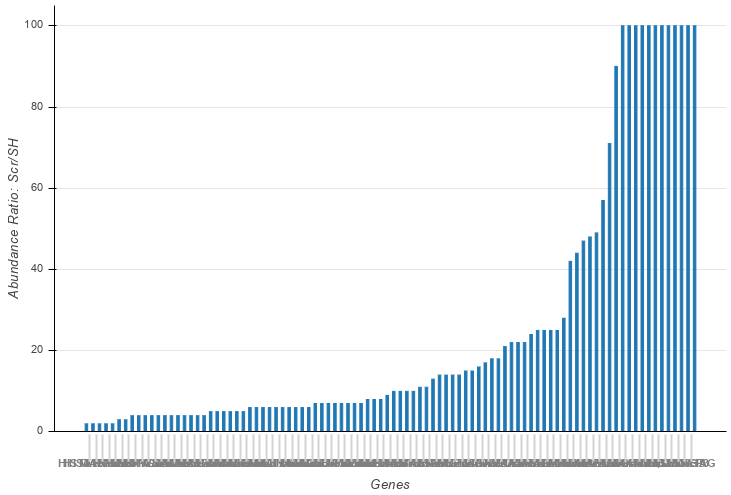

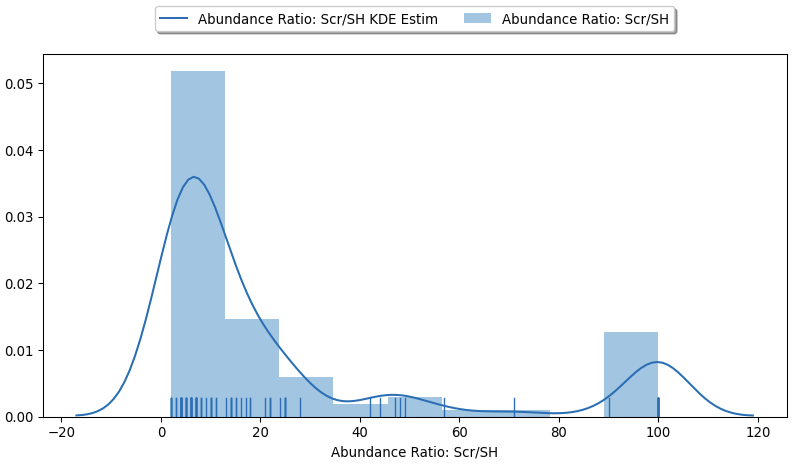

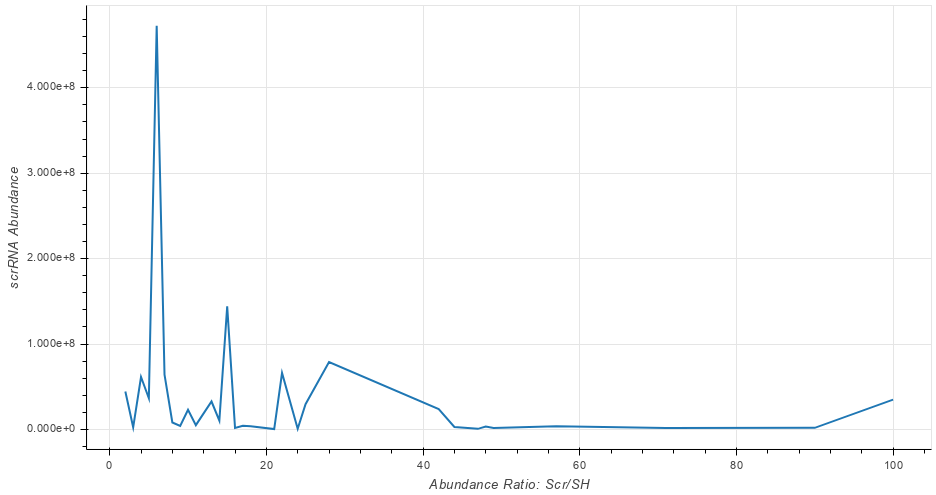
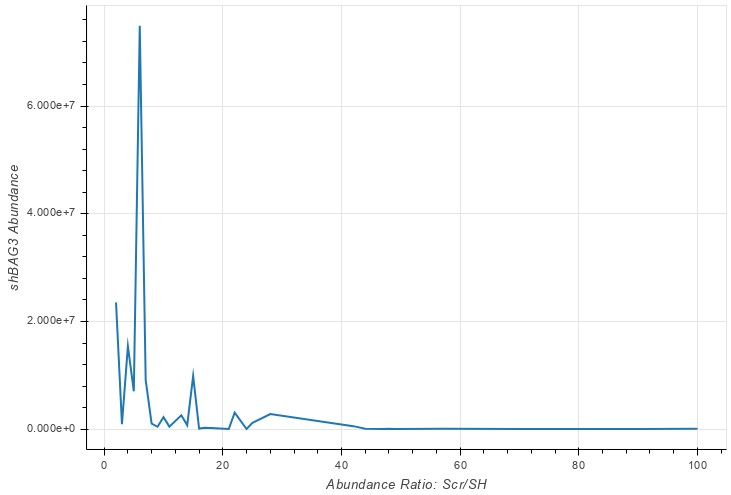

## Work in progress - more coming soon